In [1]:
# Define the URL where Label Studio is accessible and the API key for your user account
LABEL_STUDIO_URL = 'https://label.elliotnas.synology.me'
API_KEY = '4df35d9de2ebc568426662c114fba972d22fc821'
PROJECT_ID = 1

# Import the SDK and the client module
from label_studio_sdk import Client
import pandas as pd



In [2]:
# Connect to the Label Studio API and check the connection
ls = Client(url=LABEL_STUDIO_URL, api_key=API_KEY)
ls.check_connection()

project = ls.get_project(PROJECT_ID)

tasks = project.get_tasks()

In [12]:
whale_boxes = []
for task in tasks:
    for annotation in task['annotations']:
        boxes = annotation['result']
        for box in boxes:
            sequence = box['value']['sequence']

            sequence_df = pd.DataFrame(sequence)
            
            whale_boxes.append(sequence_df)

In [13]:
interpolated_whale_boxes = []
for sequence_df in whale_boxes:
    start_frame = sequence_df["frame"].min()
    end_frame = sequence_df["frame"].max()
    sequence_df.set_index('frame', inplace=True)
    
    sequence_df = sequence_df.reindex(pd.RangeIndex(start=start_frame, stop=end_frame+1, step=1))
    
    sequence_df['enabled'] = sequence_df['enabled'].ffill()
    sequence_df[['rotation', 'x', 'y', 'width', 'height', 'time']] = sequence_df[['rotation', 'x', 'y', 'width', 'height', 'time']].interpolate()
    
    interpolated_whale_boxes.append(sequence_df)

C:\Users\ellio\AppData\Local\Temp\ipykernel_14804\615443187.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sequence_df['enabled'] = sequence_df['enabled'].ffill()
C:\Users\ellio\AppData\Local\Temp\ipykernel_14804\615443187.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sequence_df['enabled'] = sequence_df['enabled'].ffill()
C:\Users\ellio\AppData\Local\Temp\ipykernel_14804\615443187.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=Fa

9817


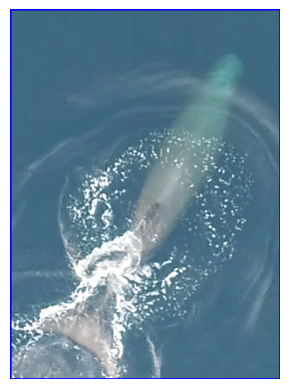

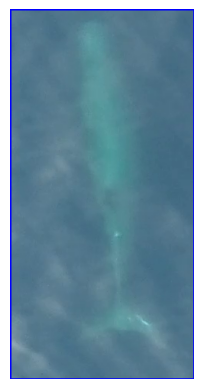

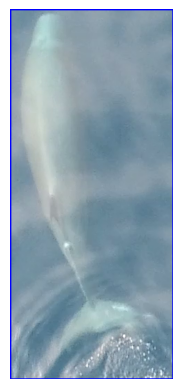

In [15]:
import cv2
from matplotlib import pyplot as plt

video_path = r"C:\Users\ellio\Desktop\Whale Hackday\2023-08-25_Phantom4_18_Gully_0015-003.MOV"

# Create a VideoCapture object
cap = cv2.VideoCapture(video_path)

# Check if the video file was successfully opened
if not cap.isOpened():
    print("Error: Unable to open video file.")
    exit()
    
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# old = 0
for frame_number in [2898, 3100, 4314]:
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame at the specified frame number
    ret, frame = cap.read()

    # Check if the frame was successfully read
    if not ret:
        print(f"Error: Unable to read frame {frame_number}.")
        exit()

    frame_height, frame_width, _ = frame.shape

    x = int(frame_width * sequence_df.loc[frame_number]["x"] / 100)
    y = int(frame_height * sequence_df.loc[frame_number]["y"] / 100)
    width = int(frame_width * sequence_df.loc[frame_number]["width"] / 100)
    height = int(frame_height * sequence_df.loc[frame_number]["height"] / 100)

    # Draw rectangle on the frame
    cv2.rectangle(frame, (x, y), (x + width, y + height), (255, 0, 0), 2)  # (255, 0, 0) is for blue color, 2 is for thickness


    # Convert frame from BGR to RGB (OpenCV uses BGR by default)
    roi = frame[y:y+height, x:x+width]
    frame_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)

    # Display the frame using matplotlib
    plt.imshow(frame_rgb)
    plt.axis('off')  # Turn off axis
    plt.show()

# Release the VideoCapture object
cap.release()

In [ ]:
from pathlib import Path

# Create a VideoCapture object
cap = cv2.VideoCapture(video_path)

# Check if the video file was successfully opened
if not cap.isOpened():
    print("Error: Unable to open video file.")
    exit()

# old = 0
for i, sequence_df in enumerate(interpolated_whale_boxes):
    for frame_number in sequence_df.index:
        # print(frame_number)
        if sequence_df.loc[frame_number]["enabled"]:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        
            # Read the frame at the specified frame number
            ret, frame = cap.read()
        
            # Check if the frame was successfully read
            if not ret:
                print(f"Error: Unable to read frame {frame_number}.")
                exit()
        
            frame_height, frame_width, _ = frame.shape
        
            x = int(frame_width * sequence_df.loc[frame_number]["x"] / 100)
            y = int(frame_height * sequence_df.loc[frame_number]["y"] / 100)
            width = int(frame_width * sequence_df.loc[frame_number]["width"] / 100)
            height = int(frame_height * sequence_df.loc[frame_number]["height"] / 100)
        
            # Convert frame from BGR to RGB (OpenCV uses BGR by default)
            roi = frame[y:y+height, x:x+width]
            frame_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    
            output_filename = f"./images/{i}/{frame_number:06d}.jpg"
            Path(output_filename).parent.mkdir(parents=True, exist_ok=True)
            cv2.imwrite(output_filename, roi)

# Release the VideoCapture object
cap.release()